In [1]:
# chrome://dino/
# https://chromedino.com/

In [2]:
# Import necessary libraries
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt
import time

# Import Gym and custom environment
import gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
import torch

In [3]:
# Define custom environment class
class WebGame(Env):
    def __init__(self):
        super().__init__()
        # Define observation and action spaces
        self.observation_space = Box(
            low=0, high=255, shape=(1, 83, 100), dtype=np.uint8
        )
        self.action_space = Discrete(3)
        # Setup screen capture parameters
        self.cap = mss()

        # Define the bounding boxes for game screen and game over screen
        self.game_location = {"top": 300, "left": 0, "width": 600, "height": 500}
        self.done_location = {"top": 400, "left": 600, "width": 760, "height": 100}

    # Step function for environment
    def step(self, action):
        action_map = {0: "space", 1: "down", 2: "no_op"}
        if action != 2:
            pydirectinput.press(action_map[action])

        done, _ = self.get_done()  # Check if game is over
        new_observation, _ = self.get_observation()  # Get new observation
        reward = 1  # Reward for every frame the dino is alive
        info = {}
        return new_observation, reward, done, False, info

    # Render the environment
    def render(self):
        cv2.imshow("Game", np.array(self.cap.grab(self.game_location))[:, :, :3])
        if cv2.waitKey(1) & 0xFF == ord("q"):
            self.close()

    # Close the environment
    def close(self):
        cv2.destroyAllWindows()

    # Restart the game
    def reset(self, seed=0):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press("space")
        return self.get_observation()

    # Get observation from the game screen
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[
            :, :, :3
        ]  # Get screen capture
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        resized = cv2.resize(gray, (100, 83))  # Resize
        channel = np.reshape(resized, (1, 83, 100))
        return channel, {}

    # Get the game over status using OCR
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[
            :, :, :3
        ]  # Get game over screen
        done_strings = ["GAME", "GAHE"]
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

In [4]:
# Create environment instance
env = WebGame()

In [12]:
obs, _ = env.get_observation()

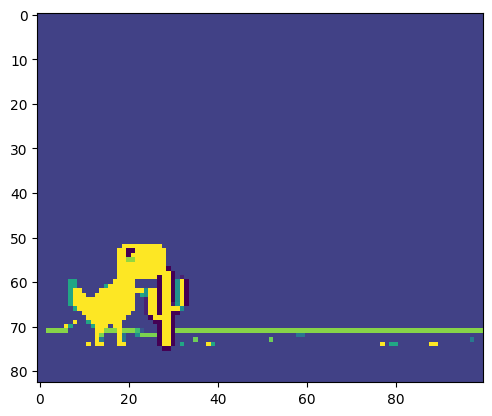

In [13]:
plt.imshow(obs[0])

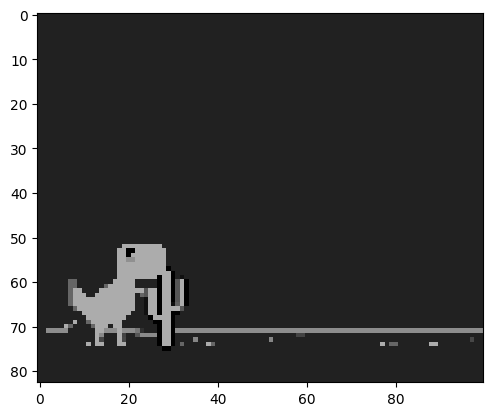

In [14]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [9]:
done, done_cap = env.get_done()
print(done)

True


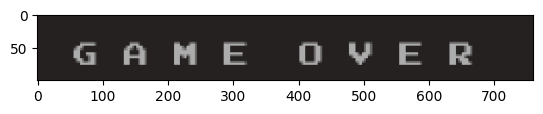

In [10]:
plt.imshow(done_cap)

In [15]:
pytesseract.image_to_string(done_cap)

'GAME OVER\n'

In [22]:
CHECKPOINT_DIR = "./train/"
LOG_DIR = "./logs/"

In [23]:
# Define callback for training and logging
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(
                self.save_path, "best_model_{}".format(self.n_calls)
            )
            self.model.save(model_path)
        return True

In [24]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [26]:
# Create and train the model
env = WebGame()

In [27]:
model = DQN(
    "CnnPolicy",
    env,
    tensorboard_log=LOG_DIR,
    verbose=1,
    buffer_size=12000,
    learning_starts=500,
    device="cuda",
    learning_rate=0.0005,
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [16]:
model.learn(total_timesteps=50000, callback=callback)
model.save("dino-ai")

Logging to ./logs/DQN_6
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 9.5      |
|    ep_rew_mean      | 9.5      |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 23       |
|    total_timesteps  | 38       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 53       |
|    total_timesteps  | 86       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 10.8     |
|    ep_rew_mean      | 10.8     |
|    exploration_rate | 0.975    |
| time/               |        

In [ ]:
# Testing the Model
model = DQN.load("dino-ai")

for episode in range(5):
    obs, _ = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        # print(action)
        obs, reward, done, _, info = env.step(int(action))
        # print(done)
        total_reward += reward

    print("Total Reward for episode {} is {}".format(episode, total_reward))